In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import sys
import os

# Add parent directory to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.config import DATA_PATHS, PLOT_STYLE
from src.theme_analysis_lda import ThemeAnalyzerLDA

# Set plot style
plt.style.use(PLOT_STYLE)
sns.set_palette("viridis")

## 1. Run LDA Analysis
We run the LDA pipeline to generate topics and assign them to reviews.

In [2]:
# Initialize and run LDA
# You can adjust n_topics to find the optimal number of themes
analyzer = ThemeAnalyzerLDA(n_topics=6)
df = analyzer.run_analysis()

Loading data...
Preprocessing 9661 reviews (Lemmatization)...


Preprocessing: 100%|██████████| 9661/9661 [00:02<00:00, 3504.90it/s]



Vectorizing text...
Running LDA with 6 topics...

Top words per topic:
Topic 0: wow, application, ever, seen, commercial, ahead, connection, happy, week, interesting
Topic 1: service, transfer, money, account, really, dont, update, balance, fix, working
Topic 2: good, best, like, working, excellent, fast, user, cbe, new, option
Topic 3: nice, use, easy, great, easy use, time, used, payment, history, worst
Topic 4: transaction, make, work, doesnt, always, simple, use, phone, like, code
Topic 5: one, dashen, amazing, super, get, well, cant, customer, cbe, branch

Assigning Dominant Topics...
✅ LDA Theme analysis saved to: ../data/processed/reviews_with_themes_lda.csv

Top words per topic:
Topic 0: wow, application, ever, seen, commercial, ahead, connection, happy, week, interesting
Topic 1: service, transfer, money, account, really, dont, update, balance, fix, working
Topic 2: good, best, like, working, excellent, fast, user, cbe, new, option
Topic 3: nice, use, easy, great, easy use, ti

## 2. Topic Interpretation
Let's look at the top words for each topic to understand what they represent.

In [3]:
# We can access the model and vectorizer from the analyzer instance
feature_names = analyzer.vectorizer.get_feature_names_out()

print("Top words per topic:")
for topic_idx, topic in enumerate(analyzer.lda_model.components_):
    top_features_ind = topic.argsort()[:-15:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    print(f"Topic {topic_idx}: {', '.join(top_features)}")

# ---------------------------------------------------------
# DEFINE TOPIC LABELS HERE
# ---------------------------------------------------------
# Based on the words printed above, give each topic a descriptive name.
# Example: If Topic 0 has 'login', 'password', 'otp' -> "Login Issues"
# Update this dictionary after running the cell once!
topic_labels = {
    0: "Topic 0 (e.g., Login/Security)",
    1: "Topic 1 (e.g., App Performance)",
    2: "Topic 2 (e.g., Transactions)",
    3: "Topic 3 (e.g., Customer Service)",
    4: "Topic 4 (e.g., UI/UX)",
    5: "Topic 5 (e.g., General Praise)"
}

# Apply the labels to the dataframe
df['topic_name'] = df['topic_id'].map(topic_labels)
print("\n✅ Topic labels applied. First 5 rows:")
print(df[['review_text', 'topic_name']].head())

Top words per topic:
Topic 0: wow, application, ever, seen, commercial, ahead, connection, happy, week, interesting, cool, ever seen, fine, difficult
Topic 1: service, transfer, money, account, really, dont, update, balance, fix, working, time, show, job, need
Topic 2: good, best, like, working, excellent, fast, user, cbe, new, option, update, application, need, work
Topic 3: nice, use, easy, great, easy use, time, used, payment, history, worst, last, year, fantastic, much
Topic 4: transaction, make, work, doesnt, always, simple, use, phone, like, code, system, see, better, application
Topic 5: one, dashen, amazing, super, get, well, cant, customer, cbe, branch, step, verification, even, update

✅ Topic labels applied. First 5 rows:
                        review_text                      topic_name
1                         Very Good    Topic 2 (e.g., Transactions)
2                              goof  Topic 5 (e.g., General Praise)
3                             good!    Topic 2 (e.g.,

## 3. Topic Distribution
How are the reviews distributed across these discovered topics?

C:\Users\yeget\AppData\Local\Temp\ipykernel_30376\4209263188.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.values, y=topic_counts.index, palette='viridis')


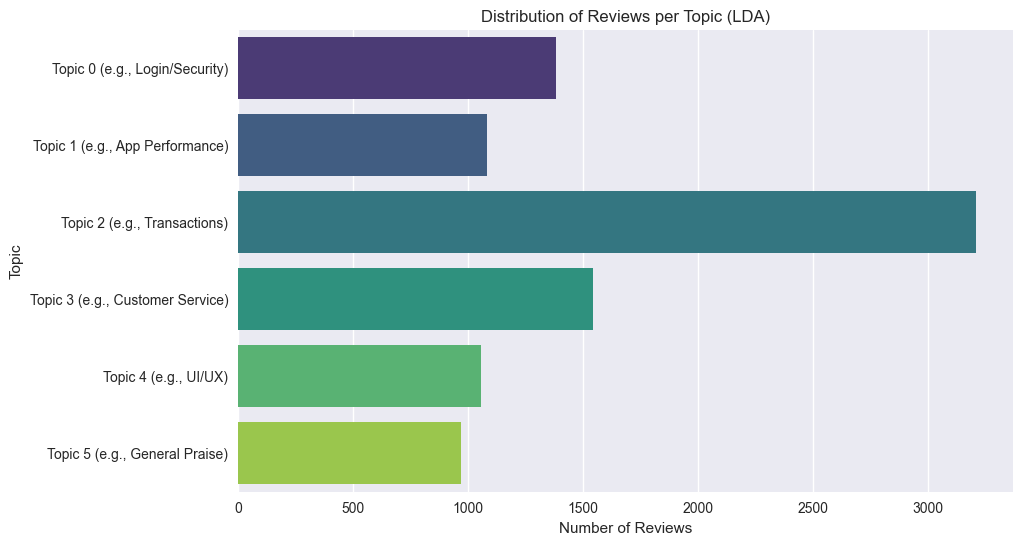

In [4]:
plt.figure(figsize=(10, 6))
# Use the mapped 'topic_name' for visualization
topic_counts = df['topic_name'].value_counts().sort_index()
sns.barplot(x=topic_counts.values, y=topic_counts.index, palette='viridis')
plt.title('Distribution of Reviews per Topic (LDA)')
plt.xlabel('Number of Reviews')
plt.ylabel('Topic')
plt.show()

## 4. Topics by Bank
Do different banks have different dominant topics?

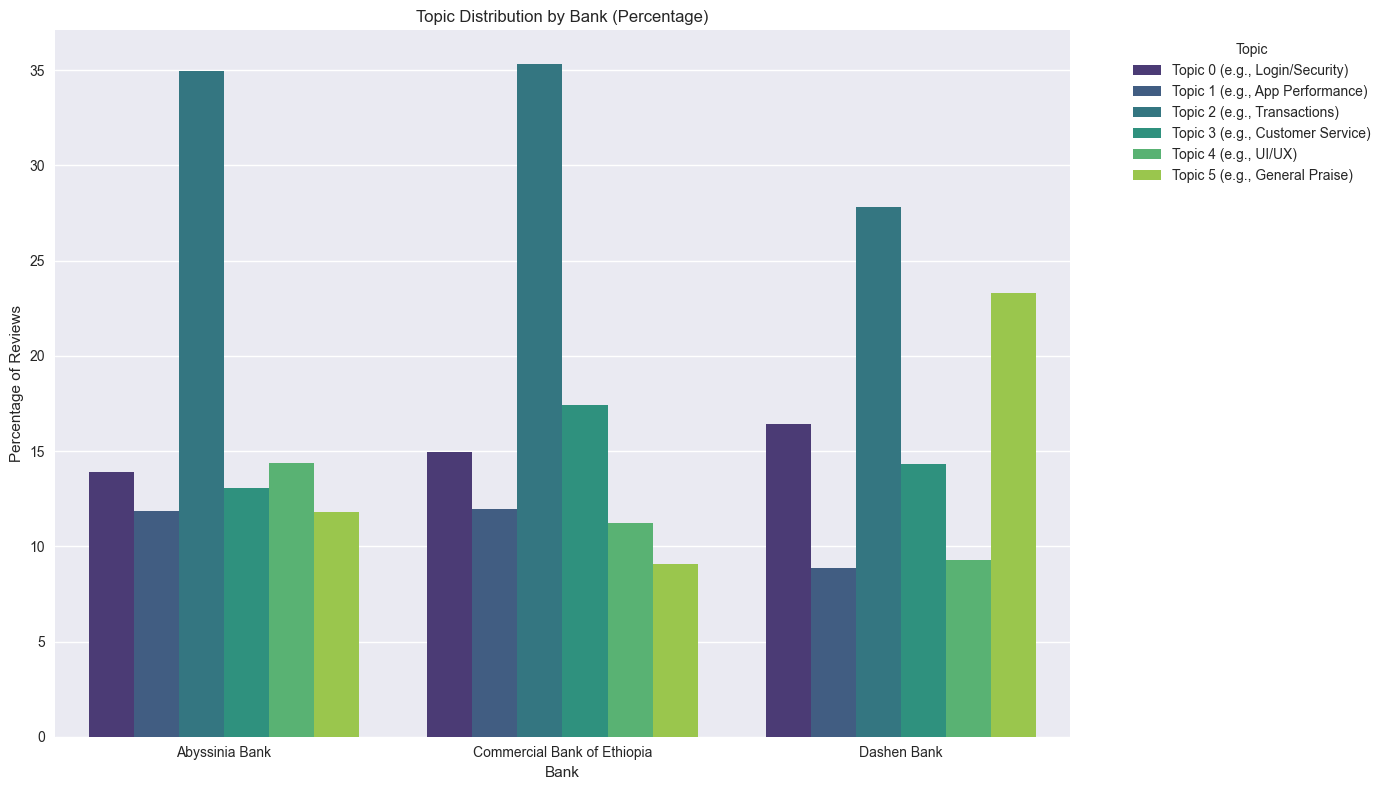

In [5]:
# Use 'topic_name' instead of 'identified_topic'
topic_by_bank = df.groupby(['bank_name', 'topic_name']).size().reset_index(name='count')
total_by_bank = df.groupby('bank_name').size().reset_index(name='total')
topic_by_bank = topic_by_bank.merge(total_by_bank, on='bank_name')
topic_by_bank['percentage'] = (topic_by_bank['count'] / topic_by_bank['total']) * 100

plt.figure(figsize=(14, 8))
sns.barplot(data=topic_by_bank, x='bank_name', y='percentage', hue='topic_name')
plt.title('Topic Distribution by Bank (Percentage)')
plt.xlabel('Bank')
plt.ylabel('Percentage of Reviews')
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 5. Sentiment by Topic
Are certain topics associated with more negative sentiment? (e.g., 'Login Issues' might be more negative than 'General Praise')

C:\Users\yeget\AppData\Local\Temp\ipykernel_30376\1367753932.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='topic_name', y=score_col, palette='coolwarm')


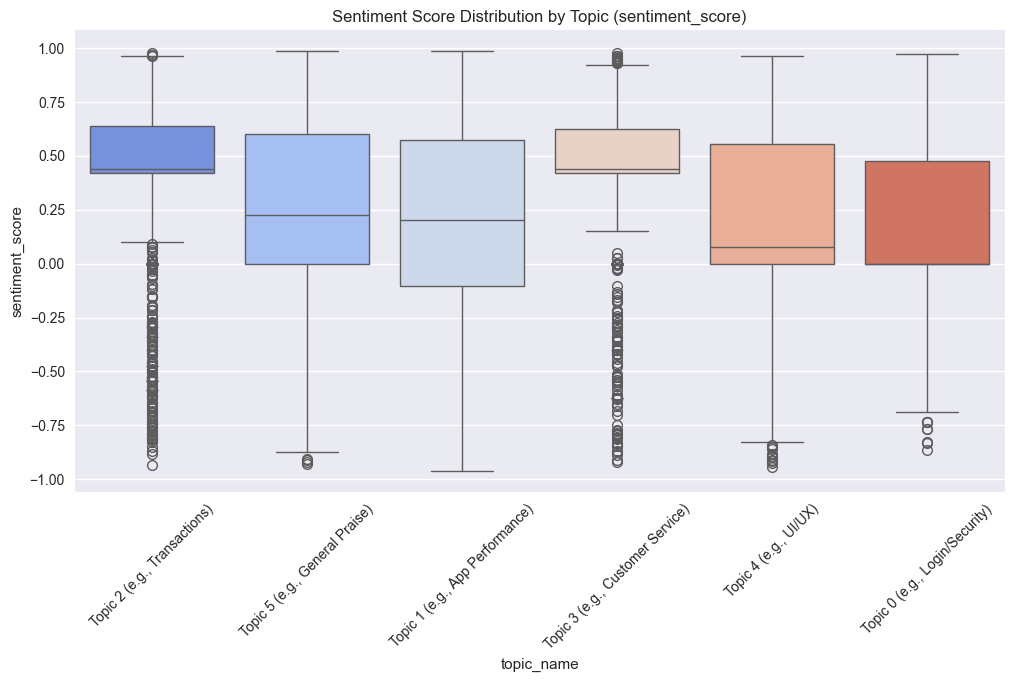

In [8]:
plt.figure(figsize=(12, 6))
# Using 'sentiment_score' (VADER) or 'bert_score' if available. Defaulting to 'sentiment_score' for now.
score_col = 'sentiment_score' if 'sentiment_score' in df.columns else 'bert_score'

sns.boxplot(data=df, x='topic_name', y=score_col, palette='coolwarm')
plt.title(f'Sentiment Score Distribution by Topic ({score_col})')
plt.xticks(rotation=45)
plt.show()

## 6. Word Clouds per Topic
Visualizing the content of each topic.

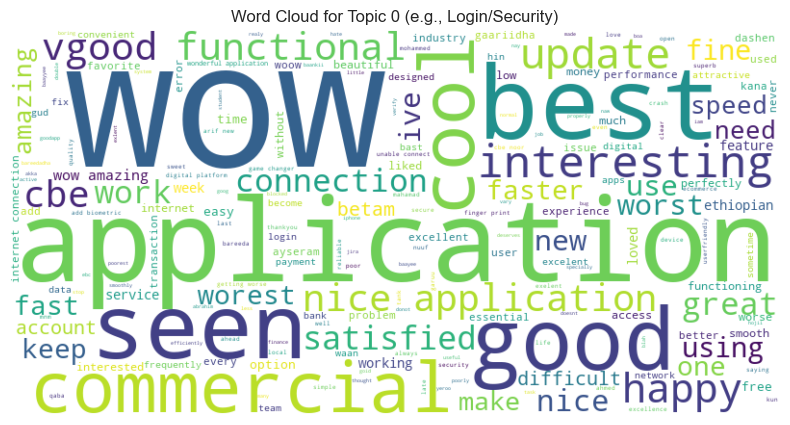

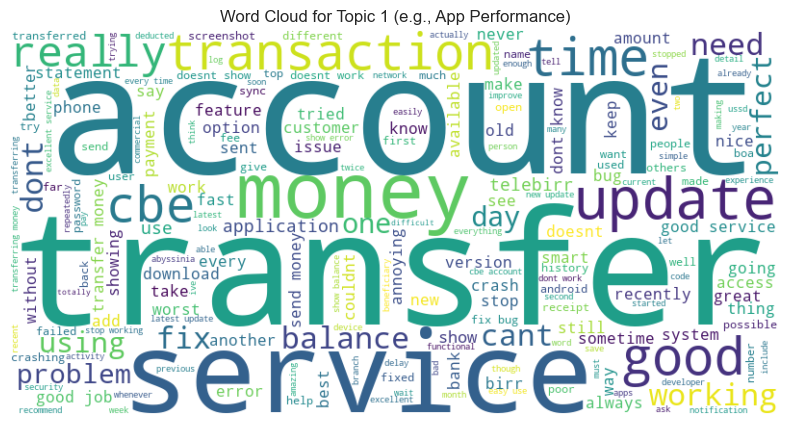

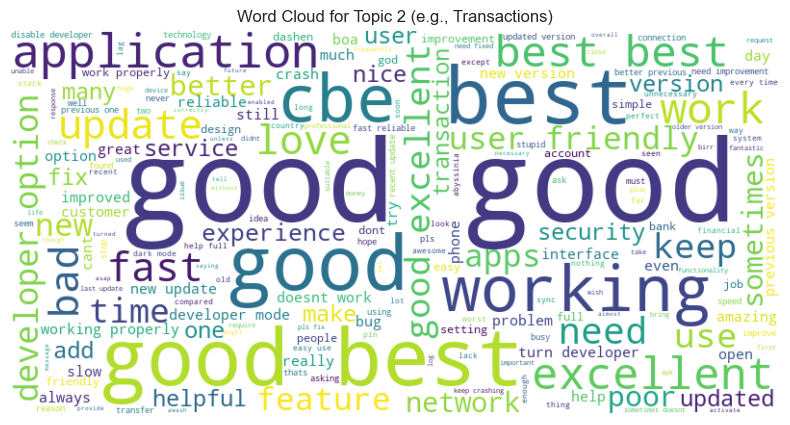

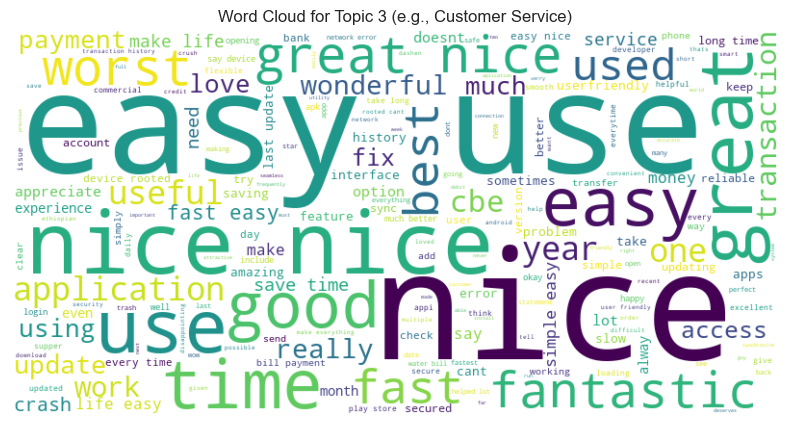

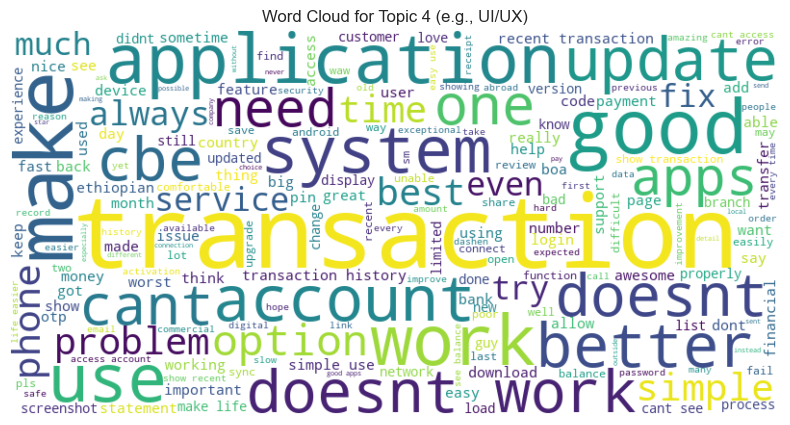

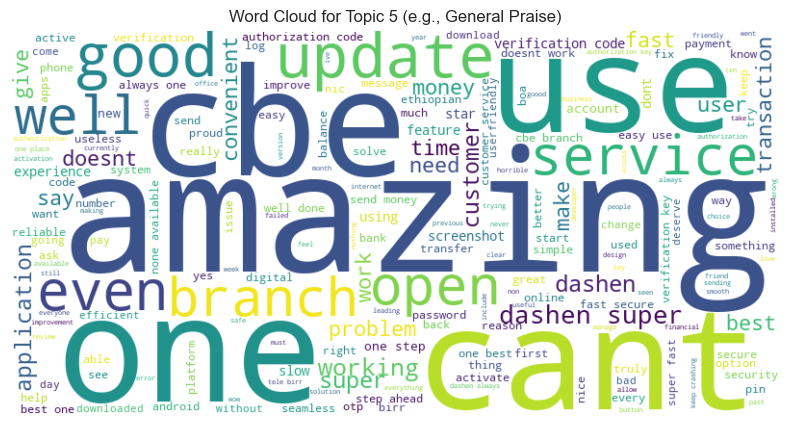

In [6]:
topics = sorted(df['topic_name'].unique())

for topic in topics:
    subset = df[df['topic_name'] == topic]
    text = " ".join(subset['clean_text'].astype(str))
    
    if len(text) < 10: continue

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {topic}')
    plt.show()

## 7. Interactive Visualization (pyLDAvis)
This provides an interactive map of the topics and their keywords.

In [7]:
try:
    import pyLDAvis
    import pyLDAvis.sklearn
    
    # Prepare data for pyLDAvis
    dtm = analyzer.vectorizer.transform(df['clean_text'])
    panel = pyLDAvis.sklearn.prepare(analyzer.lda_model, dtm, analyzer.vectorizer, mds='tsne')
    
    # Display in notebook
    pyLDAvis.enable_notebook()
    display(panel)
except ImportError:
    print("pyLDAvis not installed or failed to load.")
except Exception as e:
    print(f"Error creating pyLDAvis visualization: {e}")

pyLDAvis not installed or failed to load.
